# Miscellaneous

In [ ]:
nlp = spacy.load("en_core_web_sm")

words = {}
count = 0
X = []
ptr = 0
IL = []
for summary in tqdm(data['bookSummary']):
    count += 1
    doc = nlp(summary)
    x = []
    for token in doc:
        # print(token.text, token.pos_)
        if token.pos_ not in words:
            words[token.pos_] = {}
        word = token.text.lower()
        x.append(word)
        if word not in words[token.pos_]:
            words[token.pos_][word] = 0
        words[token.pos_][token.text.lower()] += 1
    X.append(x)
    IL.append(data['imageLink'][ptr])
    ptr += 1


print('nouns:', len(words['NOUN']))
print('proper nouns:', len(words['PROPN']))
print('verbs:', len(words['VERB']))
print('adjective:', len(words['ADJ']))


def fn_noun(word):
    return words['NOUN'][word]
def fn_noun(word):
    return words['NOUN'][word]
def fn_noun(word):
    return words['NOUN'][word]
noun = [(k, v) for k, v in sorted(words['NOUN'].items(), key=lambda item: item[1], reverse = True)]
verb = [(k, v) for k, v in sorted(words['VERB'].items(), key=lambda item: item[1], reverse=True)]
adj = [(k, v) for k, v in sorted(words['ADJ'].items(), key=lambda item: item[1], reverse = True)]
# nouns = sorted(list(words['NOUN'].keys()), key = fn_noun), reverse = True)
# verb = sorted(list(words['VERB'].keys()), key = list(words['VERB'].values()), reverse = True)
# adj = sorted(list(words['ADJ'].keys()), key = list(words['ADJ'].values()), reverse = True)
print(noun[:10])
print(verb[:10])
print(adj[:10])


dictionary = []
for type_ in ['NOUN', 'VERB', 'ADJ']:
    for word in words[type_]:
        if words[type_][word] >= 10:
            dictionary.append(word)
print(len(dictionary))


print(dictionary[:20])
print(noun[:100])
print(verb[:100])
print(adj[:100])
print(X[:10])


write({
    'dictionary': dictionary,
    'words': words,
    'X': X,
    'imageLink': IL,
    }, 'summary_test')

100%|██████████| 4052/4052 [02:10<00:00, 31.08it/s]


nouns: 15445
proper nouns: 23267
verbs: 8392
adjective: 5273
[('life', 2136), ('world', 1540), ('time', 1115), ('love', 1021), ('story', 1011), ('family', 957), ('book', 908), ('years', 870), ('man', 818), ('way', 701)]
[('will', 1953), ('can', 1608), ('’s', 1302), ('find', 732), ('must', 671), ('could', 595), ('make', 561), ('would', 497), ('become', 401), ('know', 399)]
[('new', 1407), ('own', 955), ('first', 796), ('more', 693), ('young', 685), ('old', 684), ('other', 654), ('best', 466), ('last', 401), ('human', 394)]
4540
['choice', 'consequences', 'factions', 'haunting', 'questions', 'grief', 'forgiveness', 'identity', 'loyalty', 'politics', 'love', 'day', 'celebration', 'victory', 'horrors', 'conflict', 'times', 'war', 'sides', 'secrets']
[('life', 2136), ('world', 1540), ('time', 1115), ('love', 1021), ('story', 1011), ('family', 957), ('book', 908), ('years', 870), ('man', 818), ('way', 701), ('people', 664), ('novel', 645), ('author', 581), ('woman', 579), ('year', 572), ('he

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import spacy
import json
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingRegressor
from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

# PreProcessing

In [3]:
def write(data, filename):
    with open('./drive/My Drive/ML Project/' + filename + '.json', 'w') as file:
        json.dump(data, file)

def read(filename):
    with open('./drive/My Drive/ML Project/' + filename + '.json', 'r') as file:
        data = json.load(file)
    return data

data = pd.read_csv('/content/drive/MyDrive/ML Project/data/data_train.csv', na_values='.')
data_test = pd.read_csv('/content/drive/MyDrive/ML Project/data/data_test.csv', na_values='.')
data.columns

Index(['title', 'author', 'imageLink', 'bookSummary', 'yearPublished',
       'noOfPages', 'rating', 'ratingCount', 'reviewCount', 'language',
       'noOfAwards', 'authorFollowers', 'bookFormat: mass',
       'bookFormat: hardcover', 'bookFormat: paperback', 'bookFormat: ebook',
       'bookFormat: kindle edition', 'bookFormat: audio', 'bookFormat: other',
       'genre: Science Fiction', 'genre: Adult', 'genre: Young Adult',
       'genre: Thriller', 'genre: Nonfiction', 'genre: Audiobook',
       'genre: Historical', 'genre: Contemporary', 'genre: Paranormal',
       'genre: Childrens', 'genre: Fiction', 'genre: Literature',
       'genre: Sequential Art', 'genre: Fantasy', 'genre: Mystery',
       'genre: Romance'],
      dtype='object')

In [4]:
summary = read('summary_train')
print(summary['dictionary'][:10])
print(summary['words'].keys())
print(summary['X'][:10])

['future', 'planet', 'earth', 'world', 'war', 'fact', 'life', 'kid', 'school', 'sky']
dict_keys(['PROPN', 'PUNCT', 'NOUN', 'DET', 'ADJ', 'ADP', 'VERB', 'ADV', 'AUX', 'CCONJ', 'PART', 'PRON', 'SCONJ', 'NUM', 'SYM', 'SPACE', 'X', 'INTJ'])
[['greetings', ',', 'earthlingin', 'the', 'near', '-', 'future', 'on', 'planet', 'earth', ',', 'a', 'world', 'gone', 'mad', 'where', 'never', '-', 'ending', 'war', 'is', 'a', 'fact', 'of', 'life', ',', 'kirio', 'is', 'the', 'coolest', 'kid', 'at', 'school', '.', 'up', 'in', 'the', 'sky', ',', 'a', 'giant', 'robot', 'is', 'fighting', 'a', 'fleet', 'of', 'gunships', ',', 'but', 'the', 'brilliant', 'and', 'distant', 'kirio', 'is', 'far', 'from', 'fazed', '–', 'until', 'the', 'battling', '’', 'bot', 'makes', 'an', 'unexpected', 'landing', 'in', 'kirio', '’s', 'front', 'yard', 'and', 'rings', 'the', 'bell', '.', 'but', 'the', 'worst', 'threat', 'for', 'kirio', 'could', 'be', 'what', 'stands', 'on', 'the', 'other', 'side', 'of', 'the', 'door', ':', 'an', 'ali

In [5]:
dictionary = summary['dictionary']
dictionary = list(set(dictionary))
words = summary['words']

def compare(word):
    if word in words['NOUN']:
        return words['NOUN'][word]
    elif word in words['VERB']:
        return words['VERB'][word]
    elif word in words['ADJ']:
        return words['ADJ'][word]
    else:
        return 0


dictionary = sorted(dictionary, key=compare, reverse=True)

X = summary['X']

In [6]:
print(dictionary[:10])

['life', 'world', 'new', 'story', 'time', 'love', 'book', 'family', 'years', 'man']


In [7]:
word_index = {}
for i in range(len(dictionary)):
    word_index[dictionary[i]] = i

new_X = []
for x in X:
    new_x = [0 for i in range(len(dictionary))]
    for word in x:
        if word not in word_index:
            continue
        new_x[word_index[word]] += 1
    new_X.append(new_x)


In [8]:
print(new_X[1])
print(data.values[1])
print(dictionary[:10])
new_X = np.array(new_X)
X = np.array(new_X)
Y = data.values[:,-6]


[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [13]:

def custom_mean_squared_error(y_hat, y):
    return np.sum((y_hat - y)**2 * ((abs(3.97 - y)/(0.337342))**2 + 1))/y.shape[0]

# Regression Models

Linear regression

In [41]:
print("Features:", len(X[0]))
X = np.array(new_X[:,:2000])
Y = data.values[:,6]

kfold = KFold(n_splits=5)
train_avg = 0
test_avg = 0
coeff = [0] * 2000
metric = 0
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # print(X_train.shape)
    # pca = PCA(.85)
    # pca.fit(X_train)
    # X_train = pca.transform(X_train)
    # X_test = pca.transform(X_test)
    # print(X_train.shape)
    
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    coeff = coeff + clf.coef_
    
    y_hat = clf.predict(X_test)
    test_avg += mean_squared_error(y_hat, y_test)
    metric += custom_mean_squared_error(y_hat, y_test)
    y_hat = clf.predict(X_train)
    train_avg += mean_squared_error(y_hat, y_train)
    
print(train_avg/5)
print(test_avg/5)
print(metric/5)
coeff = coeff / 5
coeff_index = []
for i in range(len(coeff)):
    coeff_index.append((coeff[i], i))
coeff_index.sort(reverse=True)


model = LinearRegression()
model.fit(X, Y)
pickle.dump(model, open('./drive/My Drive/ML Project/weights/LinearRegressionSummary.sav', 'wb'))
model = pickle.load(open('./drive/My Drive/ML Project/weights/LinearRegressionSummary.sav', 'rb'))
y_hat = model.predict(X)
print(mean_squared_error(y_hat, Y))


Features: 9948
0.08271064945964195
0.11511274592656269
0.824424561485284
0.08550101866546145


In [ ]:
for i in range(len(coeff_index)):
    idx = coeff_index[i][1]
    print(dictionary[idx],',',coeff_index[i][0])

preparing , 0.09615723302042155
foe , 0.09277528938749716
volume , 0.09082533255753275
size , 0.08655804961886492
signature , 0.08375339914642073
exile , 0.08369954719870008
illustrated , 0.07975417263640865
crucial , 0.07658823653677102
parts , 0.07598298946141954
continue , 0.07567655499957136
trauma , 0.07567158223470918
collected , 0.07538201763999926
lesson , 0.07503962955338354
images , 0.07477534789647018
mankind , 0.07253778601300782
dedicated , 0.07240467418950007
pursue , 0.07233142205777313
authority , 0.07155894816706669
recognized , 0.06959164343298231
translation , 0.0681289651151589
beings , 0.06742261472609182
horrible , 0.06646362389592389
match , 0.06588551369328467
rely , 0.06554975242721864
continues , 0.06383833878526098
editions , 0.06294705050771464
access , 0.06238555746003355
gentle , 0.06218224346837142
hunters , 0.06157083534793464
presented , 0.06123422259695962
wonderful , 0.060880231390450255
courageous , 0.060154756273737654
films , 0.05960526525829933
ch

Plots

# Neural networks

In [10]:
def model(input_shape, regularization = 0):
    X_input = Input(input_shape)
    X = Dense(50, activation='tanh',kernel_regularizer=regularizers.l2(regularization))(X_input)
    X = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(regularization))(X)
    X = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(regularization))(X)
    X = Dense(1)(X)

    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model


## Without regularization

In [26]:
X = np.array(new_X)
Y = data.values[:,6]

X = np.asarray(X).astype('float64')
Y = np.asarray(Y).astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=59)
happyModel = model((X.shape[1]))
happyModel.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
happyModel.fit(x = X_train, y = y_train, epochs = 12)
    
loss, acc = happyModel.evaluate(x = X_test, y = y_test)
y_hat = happyModel.predict(x=X_test)
y_hat = y_hat.reshape((y_hat.shape[0],))
print(custom_mean_squared_error(y_hat, y_test))

weights = happyModel.get_weights()
pickle.dump(weights, open('./drive/My Drive/ML Project/weights/SummaryANN.sav', 'wb'))
weights = pickle.load(open('./drive/My Drive/ML Project/weights/SummaryANN.sav', 'rb'))
happyModel = model((X.shape[1]))
happyModel.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
happyModel.set_weights(weights)
y_hat = happyModel.predict(X)
print(mean_squared_error(y_hat, Y))

Epoch 1/12
380/380 [==============================] - 2s 3ms/step - loss: 1.8464 - mse: 1.8464
Epoch 2/12
380/380 [==============================] - 1s 3ms/step - loss: 0.1028 - mse: 0.1028
Epoch 3/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0556 - mse: 0.0556
Epoch 4/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0376 - mse: 0.0376
Epoch 5/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0289 - mse: 0.0289
Epoch 6/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0234 - mse: 0.0234
Epoch 7/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0198 - mse: 0.0198
Epoch 8/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0169 - mse: 0.0169
Epoch 9/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0144 - mse: 0.0144
Epoch 10/12
380/380 [==============================] - 1s 3ms/step - loss: 0.0130 - mse: 0.0130
Epoch 11/12
380/380 [============================

## With Regularization

In [27]:
X = np.array(new_X)
Y = data.values[:,6]


X = np.asarray(X).astype('float64')
Y = np.asarray(Y).astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=59)

happyModel = model((X.shape[1]) , regularization=0.01)
happyModel.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
happyModel.fit(x = X_train, y = y_train, epochs = 20)
    
loss, acc = happyModel.evaluate(x = X_test, y = y_test)
y_hat = happyModel.predict(x=X_test)
y_hat = y_hat.reshape((y_hat.shape[0],))
print(custom_mean_squared_error(y_hat, y_test))


weights = happyModel.get_weights()
pickle.dump(weights, open('./drive/My Drive/ML Project/weights/SummaryANNWithRegularization.sav', 'wb'))
weights = pickle.load(open('./drive/My Drive/ML Project/weights/SummaryANNWithRegularization.sav', 'rb'))
happyModel = model((X.shape[1]))
happyModel.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
happyModel.set_weights(weights)
y_hat = happyModel.predict(X)
print(mean_squared_error(y_hat, Y))

Epoch 1/20
380/380 [==============================] - 2s 3ms/step - loss: 3.2180 - mse: 2.0655
Epoch 2/20
380/380 [==============================] - 1s 3ms/step - loss: 0.5388 - mse: 0.1203
Epoch 3/20
380/380 [==============================] - 1s 3ms/step - loss: 0.3585 - mse: 0.1087
Epoch 4/20
380/380 [==============================] - 1s 3ms/step - loss: 0.2702 - mse: 0.1006
Epoch 5/20
380/380 [==============================] - 1s 3ms/step - loss: 0.2346 - mse: 0.1068
Epoch 6/20
380/380 [==============================] - 1s 3ms/step - loss: 0.1951 - mse: 0.0997
Epoch 7/20
380/380 [==============================] - 1s 3ms/step - loss: 0.1770 - mse: 0.1019
Epoch 8/20
380/380 [==============================] - 1s 3ms/step - loss: 0.1634 - mse: 0.1028
Epoch 9/20
380/380 [==============================] - 1s 3ms/step - loss: 0.1492 - mse: 0.1006
Epoch 10/20
380/380 [==============================] - 1s 3ms/step - loss: 0.1412 - mse: 0.0992
Epoch 11/20
380/380 [============================

# Plot Models

Epoch 1/5
475/475 [==============================] - 1s 2ms/step - loss: 0.7810 - mse: 0.7810
Epoch 2/5
475/475 [==============================] - 1s 2ms/step - loss: 0.1050 - mse: 0.1050
Epoch 3/5
475/475 [==============================] - 1s 2ms/step - loss: 0.0898 - mse: 0.0898
Epoch 4/5
475/475 [==============================] - 1s 2ms/step - loss: 0.0792 - mse: 0.0792
Epoch 5/5
159/159 [==============================] - 0s 2ms/step - loss: 0.1228 - mse: 0.1228
Epoch 1/10
475/475 [==============================] - 1s 2ms/step - loss: 1.7569 - mse: 0.8141
Epoch 2/10
475/475 [==============================] - 1s 2ms/step - loss: 0.4013 - mse: 0.1213
Epoch 3/10
475/475 [==============================] - 1s 2ms/step - loss: 0.2572 - mse: 0.1138
Epoch 4/10
475/475 [==============================] - 1s 2ms/step - loss: 0.1984 - mse: 0.1099
Epoch 5/10
475/475 [==============================] - 1s 3ms/step - loss: 0.1690 - mse: 0.1091
Epoch 6/10
475/475 [==============================] - 1

<Figure size 432x288 with 0 Axes>

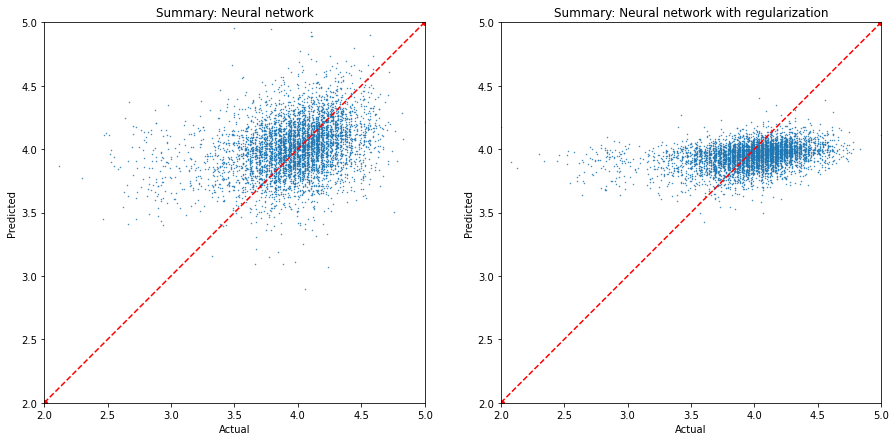

In [ ]:

plt.clf()
fig, ((ax1, ax2)) = plt.subplots(1, 2)

X = X.astype('float64')
Y = Y.astype('float64')

# def remove_samples(X_train, y_train):

#     low = 0
#     high = 0.1
#     added = []
#     while high <= 5:
#         freq = 0
#         for i in range(X_train.shape[0]):
#             if (y_train[i] >= high or y_train[i] < low):
#                 continue
#             if y_train[i] < high and y_train[i] >= low and freq < 500:
#                 added.append(i)
#                 freq += 1
#         low += 0.1
#         high += 0.1
#         print(freq)

#     X_train_new = np.ndarray((len(added), X_train.shape[1]))
#     y_train_new = np.ndarray((len(added)))

#     for i in range(len(added)):
#         X_train_new[i] = X_train[added[i]]
#         y_train_new[i] = y_train[added[i]]

#     return X_train_new, y_train_new

X_train, X_test, y_train, y_test = train_test_split(X, Y)
y_hats = np.zeros(y_test.shape)
clf = model((X.shape[1]))
clf.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
clf.fit(X_train, y_train, epochs = 5)
clf.evaluate(X_test, y_test)
y_hat_test = clf.predict(X_test)
ax1.set_title('Summary: Neural network')
ax1.scatter(y_test, y_hat_test, s = 0.2)
ax1.plot((2, 5), (2, 5), 'ro--')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_xlim(2, 5)
ax1.set_ylim(2, 5)
# fig.set_size_inches(8, *)

X_train, X_test, y_train, y_test = train_test_split(X, Y)
y_hats = np.zeros(y_test.shape)
clf = model((X.shape[1]), regularization = 0.01)
clf.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
clf.fit(X_train, y_train, epochs = 10)
clf.evaluate(X_test, y_test)
y_hat_test = clf.predict(X_test)
print(custom_mean_squared_error(y_hat_test, y_test))
ax2.set_title('Summary: Neural network with regularization')
ax2.scatter(y_test, y_hat_test, s = 0.2)
ax2.plot((2, 5), (2, 5), 'ro--')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_xlim(2, 5)
ax2.set_ylim(2, 5)
fig.set_size_inches(15, 7)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.05)
# X_train, y_train = remove_samples(X_train, y_train)
# y_hats = np.zeros(y_test.shape)
# clf = model((X.shape[1]))
# clf.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
# clf.fit(X_train, y_train, epochs = 10)
# clf.evaluate(X_test, y_test)
# y_hat_test = clf.predict(X_test)
# ax3.set_title('Neural network')
# ax3.scatter(y_test, y_hat_test, s = 0.2)
# ax3.plot((2, 5), (2, 5), 'ro--')
# ax3.set_xlabel('Actual')
# ax3.set_ylabel('Predicted')
# ax3.set_xlim(2, 5)
# ax3.set_ylim(2, 5)
# fig.set_size_inches(25, 25)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.05)
# X_train, y_train = remove_samples(X_train, y_train)
# y_hats = np.zeros(y_test.shape)
# clf = model((X.shape[1]), regularization = 0.015)
# clf.compile(optimizer = 'adam', loss = "mse", metrics = ["mse"])
# clf.fit(X_train, y_train, epochs = 30)
# clf.evaluate(X_test, y_test)
# y_hat_test = clf.predict(X_test)
# ax4.set_title('Neural network with regularization')
# ax4.scatter(y_test, y_hat_test, s = 0.2)
# ax4.plot((2, 5), (2, 5), 'ro--')
# ax4.set_xlabel('Actual')
# ax4.set_ylabel('Predicted')
# ax4.set_xlim(2, 5)
# ax4.set_ylim(2, 5)
# fig.set_size_inches(25, 25)
# plt.show()



4244.1115268081685


# Doc2Vec

In [33]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
embedding_size=100

In [34]:
document = [summary for summary in tqdm(data['bookSummary'])]
yLabels = np.array([y for y in tqdm(data['rating'])])

100%|██████████| 16206/16206 [00:00<00:00, 2137848.42it/s]


In [35]:
documents = [TaggedDocument(doc, [i]) for i, doc in tqdm(enumerate(document))]

16206it [00:00, 619828.66it/s]


In [36]:
documents[:5]

[TaggedDocument(words='GREETINGS, EARTHLINGIn the near-future on planet Earth, a world gone mad where never-ending war is a fact of life, Kirio is the coolest kid at school. Up in the sky, a giant robot is fighting a fleet of gunships, but the brilliant and distant Kirio is far from fazed–until the battling ’bot makes an unexpected landing in Kirio’s front yard and rings the bell. But the worst threat for Kirio could be what stands on the other side of the door: an alien invader robot with the face of an adorable girl!', tags=[0]),
 TaggedDocument(words="Ever since they were driven from their homelands by the Adversary, the non-human Fables have been living on the Farm—a vast property in upstate New York that keeps them hidden from the prying eyes of the mundane world. But now, after hundreds of years of isolation, the Farm is seething with revolution, fanned by the inflammatory rhetoric of Goldilocks and the Three Little Pigs. And when Snow White and her sister Rose Red stumble upon t

In [37]:
model = Doc2Vec(documents, vector_size=embedding_size, window=8, min_count=5, workers=2, dm = 1, epochs=20)

In [38]:
features = np.array([model.infer_vector(i) for i in tqdm(document)])

100%|██████████| 16206/16206 [01:53<00:00, 143.16it/s]


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
regr = RandomForestRegressor(max_depth=20, random_state=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, yLabels, test_size=0.2, random_state=0)

In [ ]:
regr.fit(X_train, y_train)

In [ ]:
regr.score(X_train, y_train)

In [ ]:
regr.score(X_test, y_test)

In [ ]:
kfold = KFold(n_splits=5)
train_avg = 0
test_avg = 0
custom_avg = 0
for train_index, test_index in kfold.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = yLabels[train_index], yLabels[test_index]
    xgb_r = RandomForestRegressor(max_depth=5, random_state=0)
    xgb_r.fit(X_train, y_train)
    y_hat = xgb_r.predict(X_train)
    train_avg += mean_squared_error(y_hat, y_train)
    y_hat = xgb_r.predict(X_test)
    test_avg += mean_squared_error(y_hat, y_test)
    custom_avg += custom_mean_squared_error(y_hat, y_test)


print('Training:', train_avg/5)
print('Testing:', test_avg/5)
print('Custom:', custom_avg/5)

In [40]:
model = RandomForestRegressor(max_depth=5, random_state=0)
model.fit(features, yLabels)
pickle.dump(model, open('./drive/My Drive/ML Project/weights/Doc2vec+RF.sav', 'wb'))